# Fundamental of Simulation Methods
**Name**: Maximilian Richter

**Matrikel Number**: 3463789

**Student ID**: hy455

## Problem Set 2: Integration of ordinary differential equations

### Problem 2.1: Order of an ODE integration scheme 
Not done because i had a busy week... :)

### Problem 2.2: Double Pendulum

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import Math, display

plt.style.use("light")

def printf(expr, prefix=""):
    """Function to print sympy nice

    Args:
        expr (sympy.expr): Any sympy expression
        prefix (str, optional): Prefix to expression in LaTeX. Defaults to "".
    """
    display(Math(prefix + sp.latex(expr)))


# Define Symbols
t, g, m_1, m_2, l_1, l_2 = sp.symbols("t g m_1 m_2 l_1 l_2")

# Define angle functions
phi_1 = sp.symbols("phi_1", cls=sp.Function)(t)
phi_2 = sp.symbols("phi_2", cls=sp.Function)(t)

# First derivative / angular velocity
dphi_1 = sp.diff(phi_1, t)
dphi_2 = sp.diff(phi_2, t)

# Second derivative / angular accelaration
ddphi_1 = sp.diff(dphi_1, t)
ddphi_2 = sp.diff(dphi_2, t)

# Change from phase space coordinates to cartesian coordinates
x1 = l_1 * sp.sin(phi_1)
y1 = -l_1 * sp.cos(phi_1)

x2 = l_1 * sp.sin(phi_1) + l_2 * sp.sin(phi_2)
y2 = -l_1 * sp.cos(phi_1) - l_2 * sp.cos(phi_2)

# Kinetic Energy
T1 = 1 / 2 * m_1 * (x1.diff(t) ** 2 + y1.diff(t) ** 2)
T2 = 1 / 2 * m_2 * (x2.diff(t) ** 2 + y2.diff(t) ** 2)
T = T1 + T2

# Potential Energy
V1 = m_1 * g * y1
V2 = m_2 * g * y2
V = V1 + V2

# Lagrange Function
L = T - V

printf(L.simplify(), "L=")

<IPython.core.display.Math object>

# (a) Lagrangian Equations of Motion
$$\frac{\mathrm{d}}{\mathrm{d} t} \frac{\partial L}{\partial \dot{\phi}_i}-\frac{\partial L}{\partial \phi_i}=0\quad\text{with}\quad i=1,2$$

In [2]:
EL_1 = sp.diff(L, phi_1) - sp.diff(sp.diff(L, dphi_1), t).simplify()
EL_2 = sp.diff(L, phi_2) - sp.diff(sp.diff(L, dphi_2), t).simplify()

printf(EL_1.simplify(), "0=")
printf(EL_2.simplify(), "0=")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# (b) Cast System of Equation into 1st-order form
Solve for $\ddot{\phi}_i$ and define $\dot{\phi}=\omega$ such that $\ddot{\phi}=\frac{\mathrm{d}}{\mathrm{d}t}\omega$ 

In [4]:
deq = sp.solve([EL_1, EL_2], (ddphi_1, ddphi_2), simplify=False, rational=False)

deq1 = deq[ddphi_1]
deq2 = deq[ddphi_2]

printf(deq1.simplify(), "\ddot{\phi}_1=")
printf(deq2.simplify(), "\ddot{\phi}_2=")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# (c) + (d) Integration of Equations of Motion with Runge Kutta 2nd and 4th Order

In [5]:
# Lambdify sympy functions to actually evaluate EoMs with values
accel1 = sp.lambdify((t, g, m_1, m_2, l_1, l_2, phi_1, phi_2, dphi_1, dphi_2), deq1)
accel2 = sp.lambdify((t, g, m_1, m_2, l_1, l_2, phi_1, phi_2, dphi_1, dphi_2), deq2)
vel1 = sp.lambdify(dphi_1, dphi_1)
vel2 = sp.lambdify(dphi_2, dphi_2)

In [6]:
def dydt(S, t, g, m_1, m_2, l_1, l_2):
    phi_1, z_1, phi_2, z_2 = S
    return np.array(
        [
            vel1(z_1),
            accel1(t, g, m_1, m_2, l_1, l_2, phi_1, phi_2, z_1, z_2),
            vel2(z_2),
            accel2(t, g, m_1, m_2, l_1, l_2, phi_1, phi_2, z_1, z_2),
        ]
    )


def rungeKutta2nd(t0, y0, t, h, *args):
    n = round((t - t0) / h)
    y = y0
    solution = []
    for _ in range(n):
        k1 = h * dydt(y, t0, *args)
        k2 = h * dydt(y + 0.5 * k1, t0 + 0.5 * h, *args)

        y = y + (1.0 / 6.0) * (k1 + 2 * k2)
        t0 = t0 + h

        solution.append(y)
    return np.array(solution)


def rungeKutta4th(t0, y0, t, h, *args):
    n = round((t - t0) / h)
    y = y0
    solution = []
    for i in range(1, n + 1):
        k1 = h * dydt(y, t0, *args)
        k2 = h * dydt(y + 0.5 * k1, t0 + 0.5 * h, *args)
        k3 = h * dydt(y + 0.5 * k2, t0 + 0.5 * h, *args)
        k4 = h * dydt(y + k3, t0 + h, *args)

        y = y + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        t0 = t0 + h

        solution.append(y)
    return np.array(solution)

In [7]:
# Constants
g   = 1.0 # Gravitational acceleration
l_1 = 2.0 # Length of first pendulum
l_2 = 1.0 # Length of second pendulum
m_1 = 0.5 # Mass of first pendulum
m_2 = 1.0 # Mass of second pendulum

# Initial angles
phi1_0 = 180 / 360 * np.pi * 2
phi2_0 = -181 / 360 * np.pi * 2

# Initial angular velocities
dphi1_0 = 0
dphi2_0 = 0

# Initial state
y0 = [phi1_0, dphi1_0, phi2_0, dphi2_0]  

t0 = 0    # Start time
t  = 100  # Total time steps
h  = 0.05 # Step size

# Perform integration
sol_rk2 = rungeKutta2nd(t0, y0, t, h, g, m_1, m_2, l_1, l_2)
sol_rk4 = rungeKutta4th(t0, y0, t, h, g, m_1, m_2, l_1, l_2)

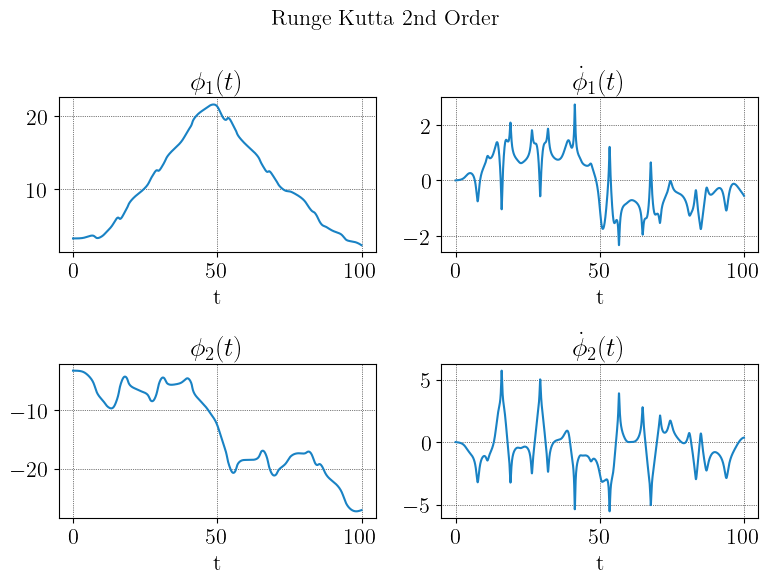

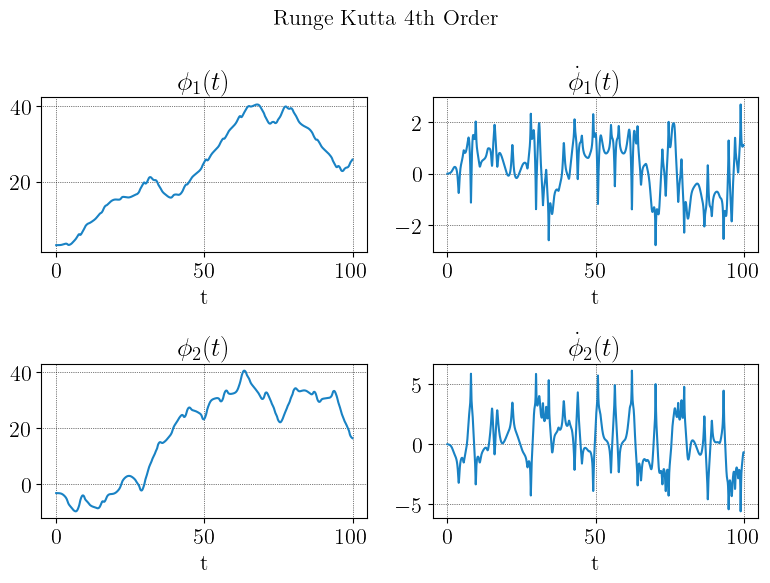

In [8]:
plt.rcParams['figure.figsize'] = [8,6]

def plot_evolution(sol, title):
    """Plot time evolution of phase space variables

    Args:
        sol (np.array): Solution of integration
        title (string): Title of the Integrator
    """
    fig, ax = plt.subplots(2, 2)
    fig.suptitle(title, fontsize=16)
    t = np.arange(0, 100, 0.05)
    ax[0, 0].plot(t, sol[:, 0])
    ax[0, 1].plot(t, sol[:, 1])
    ax[1, 0].plot(t, sol[:, 2])
    ax[1, 1].plot(t, sol[:, 3])

    ax[0, 0].set_title("$\phi_1(t)$")
    ax[0, 1].set_title("$\dot{\phi}_1(t)$")
    ax[1, 0].set_title("$\phi_2(t)$")
    ax[1, 1].set_title("$\dot{\phi}_2(t)$")

    ax[0, 0].set_xlabel("t")
    ax[0, 1].set_xlabel("t")
    ax[1, 0].set_xlabel("t")
    ax[1, 1].set_xlabel("t")

    plt.tight_layout()
    plt.show()


plot_evolution(sol_rk2, "Runge Kutta 2nd Order")
plot_evolution(sol_rk4, "Runge Kutta 4th Order")

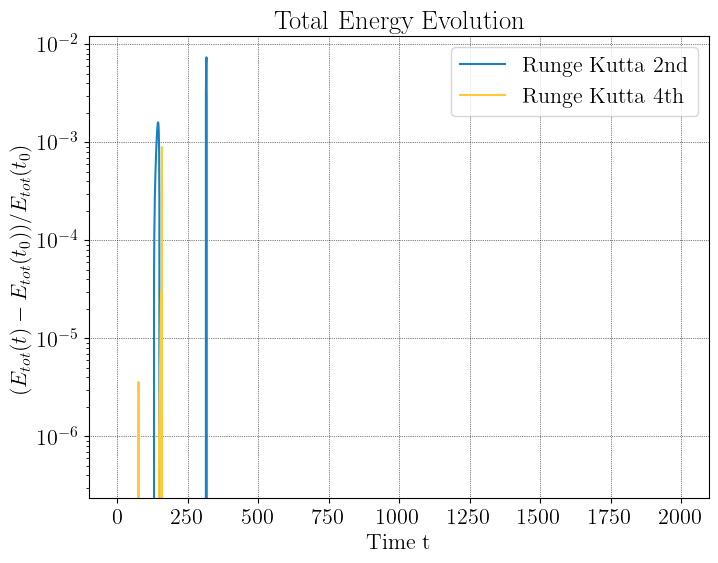

In [9]:
def get_coords(phi_1, phi_2):
    """Get cartesian coordinates from angles

    Args:
        phi_1 (float): Angle of first pendulum
        phi_2 (float): Angle of second pendulum

    Returns:
        Tuple: Cartesian coordinates
    """
    x1 = l_1 * np.sin(phi_1)
    y1 = -l_1 * np.cos(phi_1)

    x2 = l_1 * np.sin(phi_1) + l_2 * np.sin(phi_2)
    y2 = -l_1 * np.cos(phi_1) - l_2 * np.cos(phi_2)
    return x1, y1, x2, y2


def get_energy(w1, w2, l1, y1, l2, y2, m1, m2, phi1, phi2, g):
    """Get tota energy from all double pendulum variables"""
    # Kinetic Energy
    T = (
        1
        / 2
        * (
            m1 * l1**2 * w1**2
            + m2 * (l1**2 * w1**2 + l2**2 * w2**2 + 2 * l1 * l2 * w1 * w2 * np.cos(phi1 - phi2))
        )
    )
    # Potential Energy
    V = g * m1 * y1 + g * m2 * y2
    return T + V


def plot_total_energy(sol, label):
    """Plot total energy with label

    Args:
        sol (np.array): Solution of integration
        label (str): Title of Integrator
    """
    _, y1, _, y2 = get_coords(sol[:, 0], sol[:, 2])
    phi1, w1, phi2, w2 = (sol[:, 0],sol[:, 1],sol[:, 2],sol[:, 3])

    Etot = get_energy(w1, w2, l_1, y1, l_2, y2, m_1, m_2, phi1, phi2, g)

    plt.plot((Etot - Etot[0]) / Etot[0], label=label)
    plt.yscale("log")


plot_total_energy(sol_rk2, "Runge Kutta 2nd")
plot_total_energy(sol_rk4, "Runge Kutta 4th")
plt.xlabel("Time t")
plt.ylabel("$(E_{tot}(t)-E_{tot}(t_0))/E_{tot}(t_0)$")
plt.title("Total Energy Evolution")
plt.legend()

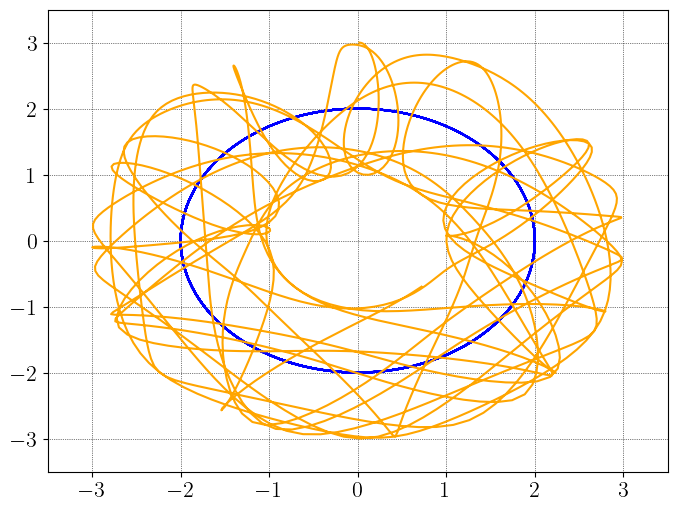

In [10]:
# Check if result seems valid
x1, y1, x2, y2 = get_coords(sol_rk4[:, 0], sol_rk4[:, 2])

extent = l_1 + l_2 + 0.5
plt.xlim(-extent, extent)
plt.ylim(-extent, extent)

plt.plot(x1, y1, "-", color="blue")
plt.plot(x2, y2, "-", color="orange")

In [11]:
def plot_timestep(timestep):
    """Plot double pendulum snapshot in cartesian coordinates and save as picture

    Args:
        timestep (int): Index for evaluation
    """
    space = l_1 + l_2 + 0.5
    plt.xlim(-space, space)
    plt.ylim(-space, space)

    # Plot origin and mass points
    plt.plot(0, 0, "o", color="black")
    plt.plot(x1[timestep], y1[timestep], "o", color="blue")
    plt.plot(x2[timestep], y2[timestep], "o", color="orange")

    # Plot trajectories of masses
    plt.plot(x1[:timestep], y1[:timestep], "-", color="blue")
    plt.plot(x2[:timestep], y2[:timestep], "-", color="orange")

    # Plot joints 
    plt.plot([0, x1[timestep]], [0, y1[timestep]], color="black")
    plt.plot([x1[timestep], x2[timestep]], [y1[timestep], y2[timestep]], color="black")

    # Save as PNG
    plt.savefig(f"./pictures/output{str(timestep).zfill(4)}.png", dpi=100)
    plt.clf()


In [13]:
# Use multiprocessing because i am inpatient and waiting is annoying
import multiprocessing as mp

# Use commong figure 
plt.figure(figsize=(5, 5))

# Good old friend the mp.Pool, using all CPUs available
with mp.Pool() as p:
    p.map(plot_timestep, np.arange(0, int(t / 0.05)))

<Figure size 500x500 with 0 Axes>

In [14]:
# Create MP4 movie with ffmpeg
!ffmpeg -y -r 30 -i ./pictures/output%04d.png movie2.mp4
!rm -rf ./pictures

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


In [15]:
# Plot movie in markdown
from IPython.display import Video

Video("movie2.mp4")